Liav

# Trading Strategies Portfolio Optimization

**Porfolio Optimization Reminder**

Financial portfolio optimization is the process of selecting the best distribution of assets to achieve a specific investment goal, such as maximizing returns or minimizing risk.

**Adding a Twist**

Instead of applying the optimzation to a group of assets, we will apply it to a group of trading strategies performances. The goal is to find the best combination of strategies and allocations that maximizes returns while minimizing risk.

### Imports

In [1]:
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt
from typing import Optional, TypeAlias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from strategy_portfolio_opt.constrained_min import ConstrainedMin

### Tickers + Data download and split

In [2]:
tickers = {
    "tech": ["AAPL", "MSFT", "TSLA"],
    "healthcare": ["JNJ", "PFE", "MRK"],
    "financials": ["JPM", "BAC", "WFC"],
    "energy": ["XOM", "CVX", "SLB"],
    "consumer": ["PG", "KO", "WMT"],
    "commodities": ["GC=F", "CL=F"]
}

TEST_CUTOFF = pd.Timestamp("2023-01-01", tz="UTC")

In [ ]:
# for sector, symbols in tickers.items():
#     print(f"Fetching data for {sector} sector...")
#     for symbol in symbols:
#         try:
#             ticker_data = yf.Ticker(symbol)
#             hist = ticker_data.history(start="2010-01-01")
            
#             mask_test = hist.index >= TEST_CUTOFF
#             df_test = hist.loc[mask_test].copy()
#             df_train = hist.loc[~mask_test].copy()

#             train_path = f"historical_data/{symbol}_train.csv"
#             test_path  = f"historical_data/{symbol}_test.csv"
            
#             df_train.to_csv(train_path)
#             df_test.to_csv(test_path)
#             print(f"Split '{symbol}' →")
#             print(f"    TRAIN ({len(df_train)} rows) → {train_path}")
#             print(f"    TEST  ({len(df_test)} rows) → {test_path}")

#             print(f"{symbol} data fetched successfully.")
#         except Exception as e:
#             print(f"Error fetching data for {symbol}: {e}")
#     print(f"Finished fetching data for {sector} sector.\n")

## Trading Strategies

* A trading strategy is a set of rules that defines how we act (enter and exit trades) in the financial markets.
* A trade is also known as a position, which can be thought of as a bet on the future price of an asset.
    - We can bet on the price going up (long position) or down (short position).

### Trend Following - Moving Average Crossover

* A trend-following strategy is a type of trading strategy that aims to capture gains through the analysis of an asset's momentum in a particular direction.
* A moving average is the avergae of last n prices of an asset at each time point. It smooths out price data by creating a constantly updated average price.
* Moving Average Crossover is a common trend-following strategy that uses two moving averages (short-term and long-term) to identify the direction of the trend.
    - If the short-term moving average crosses above the long-term moving average, it is a signal to enter a long position (buy).
    - If the short-term moving average crosses below the long-term moving average, it is a signal to enter a short position (sell).
* In our case, we will use the following parameters for the moving averages:
  - short_window = 30 (1 month)
  - long_window = 180 (6 months)

In [3]:
def moving_average_crossover(df: pd.DataFrame, short_window: int = 30, long_window: int = 180) -> pd.DataFrame:
    """
    Compute a simple moving‐average crossover strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    short_window : int
        Window size for the short SMA (e.g., 20 days).
    long_window : int
        Window size for the long SMA (e.g., 50 days).

    Returns
    -------
    pd.DataFrame
        Original DataFrame with the following added columns:
          - 'SMA_short' : short‐period moving average
          - 'SMA_long'  : long‐period moving average
          - 'Signal'    : 1 when short crosses above long,
                          -1 when short crosses below long, else 0
    """

    df = df.copy()

    # Ensure 'Date' is a datetime type and set as index if not already
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute Simple Moving Averages
    df["SMA_short"] = df["Close"].rolling(window=short_window, min_periods=1).mean()
    df["SMA_long"]  = df["Close"].rolling(window=long_window, min_periods=1).mean()

    # 2) Generate raw crossover signals: 
    #    - When SMA_short > SMA_long → 1 (long), when SMA_short < SMA_long → 0
    df["Crossover"] = np.where(df["SMA_short"] > df["SMA_long"], 1, 0)

    # 3) The actual “Signal” is the change in Crossover:
    #    - A rising edge (0→1) means a buy signal (1)
    #    - A falling edge (1→0) means a sell signal (−1)
    df["Signal"] = df["Crossover"].diff().fillna(0)
    df["Signal"] = df["Signal"].map({1.0: 1, -1.0: -1}).fillna(0).astype(int)

    # Rows where no crossover event happen remain at 0
    # Cleanup temporary column if you don’t need it:
    df.drop(columns=["Crossover"], inplace=True)

    return df

<img src="ma-crossover.png.webp" alt="Moving Average Crossover Strategy" style="width: 100%; max-width: 800px; height: auto;">

### Mean Reversion - Bollinger Bands

* A mean reversion strategy is a type of trading strategy that assumes that the price of an asset will revert to its mean (average) over time.
* Bollinger Bands are a volatility indicator that consists of a middle band (simple moving average) and two outer bands (standard deviations away from the middle band).
* A Bollinger Band strategy is a mean reversion strategy that uses Bollinger Bands to identify overbought and oversold conditions.
    - If the price is above the upper band, it is a signal to enter a short position (sell).
    - If the price is below the lower band, it is a signal to enter a long position (buy).
* In our case, we will use the following parameters for the Bollinger Bands:
    - window = 50 (days)
    - num_std = 3

In [4]:
def bollinger_bands_strategy(df: pd.DataFrame, window: int = 50, num_std: float = 3.0) -> pd.DataFrame:
    """
    Compute a simple Bollinger Bands breakout strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    window : int
        Rolling window size for moving average and standard deviation.
    num_std : float
        Number of standard deviations for upper/lower bands.

    Returns
    -------
    pd.DataFrame
        Original DataFrame with these added columns:
          - 'BB_mid'   : rolling mean (middle band)
          - 'BB_std'   : rolling standard deviation
          - 'BB_upper' : BB_mid + num_std * BB_std
          - 'BB_lower' : BB_mid − num_std * BB_std
          - 'Signal'   :  1 when Close < BB_lower (buy)
                          -1 when Close > BB_upper (sell), else 0
    """

    df = df.copy()

    # Ensure 'Date' is datetime and set as index if needed
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute rolling mean (mid) and rolling std (std) over 'window'
    df["BB_mid"] = df["Close"].rolling(window=window, min_periods=1).mean()
    df["BB_std"] = df["Close"].rolling(window=window, min_periods=1).std(ddof=0)

    # 2) Compute upper and lower bands
    df["BB_upper"] = df["BB_mid"] + (num_std * df["BB_std"])
    df["BB_lower"] = df["BB_mid"] - (num_std * df["BB_std"])

    # 3) Generate signals only on crosses (not while staying outside bands):
    #
    #    - Sell (-1) when price crosses above the upper band from below
    
    # Track position relative to bands: -1 (below lower), 0 (between), 1 (above upper)
    band_position = np.where(df["Close"] < df["BB_lower"], -1,
                            np.where(df["Close"] > df["BB_upper"], 1, 0))
    
    # Signal only when band position changes
    band_position_prev = np.roll(band_position, 1)
    band_position_prev[0] = 0  # First value has no previous
    
    conditions = [
        (band_position == -1) & (band_position_prev != -1),  # crossed below lower band
        (band_position == 1) & (band_position_prev != 1),    # crossed above upper band
    ]
    choices = [1, -1]
    
    df["Signal"] = np.select(conditions, choices, default=0).astype(int)

    return df

<img src="bollinger-bands.jpg.webp" alt="Bollinger Bands Strategy" style="width: 100%; max-width: 800px; height: auto;">

## Backtesting

* Backtesting is the process of testing a trading strategy on historical data to see how it would have performed in the past.
* It involves simulating trades based on historical price data and the rules of the trading strategy.
* It is a crucial step in the development of a trading strategy, as it allows us to evaluate the performance of the strategy and make adjustments, such as applying optimizations before deploying it in live trading.

In [5]:
def backtest(
    df: pd.DataFrame,
    price_col: str = "Close",
    signal_col: str = "Signal"
) -> list[float]:
    """
    Backtest a strategy that can go long (signal=+1), short (signal=-1), or flat (signal=0).
    For each change in signal, it closes any open position and (if new signal != 0) opens a new position.
    Returns a list of percent PnLs for each completed trade.

    Parameters
    ----------
    df : pd.DataFrame
        Must be sorted in ascending date order and contain:
          - price_col   : price at which to execute trades (float)
          - signal_col  : integer signal (+1=open long, -1=open short, 0=flat)
    price_col : str
        Name of the column with execution prices.
    signal_col : str
        Name of the column with signals (+1, -1, 0).

    Returns
    -------
    List[float]
        Percent PnLs for each round-trip (long or short) trade.
    """
    pnls: list[float] = []
    current_position = 0   # +1 for long, -1 for short, 0 for flat
    entry_price = None     # price at which the current position was opened

    for _, row in df.iterrows():
        sig = int(row[signal_col])
        price = float(row[price_col])

        if current_position == 0 and sig != 0:
            # Opening a new position
            current_position = sig
            entry_price = price
            continue  # Move to next row after opening position
        elif current_position == 1 and sig == -1:
            # Closing long position and opening short
            last_price = price
            pnl = (last_price - entry_price) / entry_price * 100.0
            pnls.append(pnl)
            current_position = -1
            entry_price = last_price
            continue  # Move to next row after closing long and opening short
        elif current_position == -1 and sig == 1:
            # Closing short position and opening long
            last_price = price
            pnl = (entry_price - last_price) / entry_price * 100.0
            pnls.append(pnl)
            current_position = 1
            entry_price = last_price
            continue

        # If sig == current_position, do nothing (hold the position)
        # If sig == 0 and current_position == 0, do nothing (remain flat)

    # At the end: if a position is still open, close it at the last price
    if current_position != 0 and entry_price is not None:
        last_price = float(df.iloc[-1][price_col])
        if current_position == 1:
            pnl = (last_price - entry_price) / entry_price * 100.0
        else:  # current_position == -1
            pnl = (entry_price - last_price) / entry_price * 100.0

        pnls.append(pnl)

    return pnls

In [6]:
def generate_backtest_pnl(split: str) -> pd.DataFrame: 
    pnls = {}
    for sector, symbols in tickers.items():
        print(f"Processing strategies for {sector} sector...")
        for symbol in symbols:
            try:
                file_path = Path(f"historical_data/{symbol}_{split}.csv")
                if not file_path.exists():
                    print(f"File {file_path} does not exist. Skipping.")
                    continue

                df = pd.read_csv(file_path)

                # Apply moving average crossover strategy
                df_ma = moving_average_crossover(df)
                ma_pnls = backtest(df_ma)

                pnls[f"{symbol}_ma_startegy"] = pd.Series(ma_pnls)

                # Apply Bollinger Bands strategy
                df_bb = bollinger_bands_strategy(df)
                bb_pnls = backtest(df_bb)

                pnls[f"{symbol}_bb_strategy"] = pd.Series(bb_pnls)

            except Exception as e:
                print(f"Error processing {symbol}: {e}")
        print(f"Finished processing strategies for {sector} sector.\n")
    return pd.DataFrame(pnls)

In [7]:
train_pnls = generate_backtest_pnl("train")
train_pnls

Processing strategies for tech sector...
Finished processing strategies for tech sector.

Processing strategies for healthcare sector...
Finished processing strategies for tech sector.

Processing strategies for healthcare sector...
Finished processing strategies for healthcare sector.

Processing strategies for financials sector...
Finished processing strategies for healthcare sector.

Processing strategies for financials sector...
Finished processing strategies for financials sector.

Processing strategies for energy sector...
Finished processing strategies for financials sector.

Processing strategies for energy sector...
Finished processing strategies for energy sector.

Processing strategies for consumer sector...
Finished processing strategies for energy sector.

Processing strategies for consumer sector...
Finished processing strategies for consumer sector.

Processing strategies for commodities sector...
Finished processing strategies for commodities sector.

Finished processin

,AAPL_ma_startegy,AAPL_bb_strategy,MSFT_ma_startegy,MSFT_bb_strategy,TSLA_ma_startegy,TSLA_bb_strategy,JNJ_ma_startegy,JNJ_bb_strategy,PFE_ma_startegy,PFE_bb_strategy,...,PG_ma_startegy,PG_bb_strategy,KO_ma_startegy,KO_bb_strategy,WMT_ma_startegy,WMT_bb_strategy,GC=F_ma_startegy,GC=F_bb_strategy,CL=F_ma_startegy,CL=F_bb_strategy
0,49.589463,-131.267388,-11.014281,21.347019,7.539275,0.602409,-8.370455,4.453945,12.054430,3.352359,...,-2.805842,31.752780,-3.000686,51.856354,-2.522509,6.780456,47.802447,10.310346,-14.271722,30.608438
1,-6.544162,-9.867989,-4.419142,-6.788845,4.771156,53.656543,-8.080058,-2.057983,-7.560413,-15.715010,...,-6.164511,-1.935601,-7.329753,-7.826105,0.090575,32.412818,-6.621704,11.335386,-18.061110,11.692152
2,49.038624,-55.404269,-4.018756,22.449196,22.801610,-267.525692,-4.031361,9.106836,62.876204,27.996292,...,-1.484294,32.857743,21.108241,6.855790,-0.184645,-6.986206,-4.991377,9.202879,20.776394,26.711301
3,3.222370,26.543154,-8.948469,-15.664063,-3.871777,77.434354,-10.102196,-36.429820,-6.473379,-57.083693,...,-4.945807,0.651537,-4.421963,-20.873727,-5.286194,26.750356,-4.630190,-17.963998,-0.330424,25.444111
4,70.229276,-0.395516,-8.335603,13.011390,-8.016019,11.745965,0.022279,50.047384,11.629184,1.885608,...,-7.324464,6.435198,7.525708,16.960421,-2.937956,14.137462,-4.627755,14.487715,-13.642713,-7.991194
5,5.690526,12.634359,1.425746,11.787100,-18.692812,36.391461,-3.093744,4.901528,-2.508550,3.034574,...,-7.792192,-34.462009,-6.269064,-10.170006,-6.118985,-5.620754,18.014194,4.599261,-10.354789,28.950866
6,67.424797,-11.617770,5.084281,26.847389,-12.371528,-0.247891,-4.093975,6.938610,-2.874946,23.090993,...,-1.304222,42.905955,1.657471,3.679809,25.303978,1.455846,-3.158981,-9.390124,-2.565711,17.570096
7,-16.758909,135.165982,-3.120221,-91.530193,-17.427777,14.539199,-7.855739,-9.924339,-0.820447,3.161699,...,-9.421929,NaN,-5.486006,-3.298783,-6.372334,37.860323,0.053472,5.630571,-7.158207,50.508747
8,38.115850,9.337438,12.429010,54.919548,-0.214054,-960.769572,62.667037,8.725940,-1.375970,19.892313,...,23.679962,NaN,-3.592836,25.379593,4.572661,0.159804,-1.505776,-34.928236,-2.357070,255.284296
9,-6.091799,NaN,-4.308968,-71.663430,-11.369323,-49.183167,-2.564108,-0.817640,-9.555198,-2.388954,...,-2.853877,NaN,-5.878900,NaN,-3.335599,20.199781,-0.543225,5.313603,37.329225,27.432185


## Returns and Covariance Matrix

In [8]:
expected_returns = train_pnls.mean().values
cov_matrix = train_pnls.cov()
cov_mat = cov_matrix.values

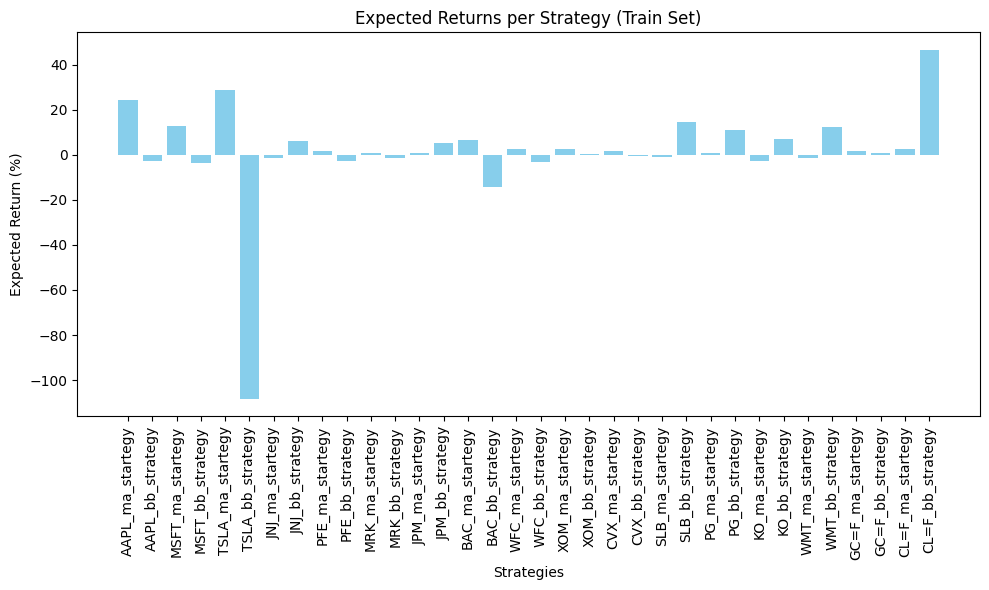

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(train_pnls.columns, expected_returns, color='skyblue')
plt.title("Expected Returns per Strategy (Train Set)")
plt.xlabel("Strategies")
plt.ylabel("Expected Return (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

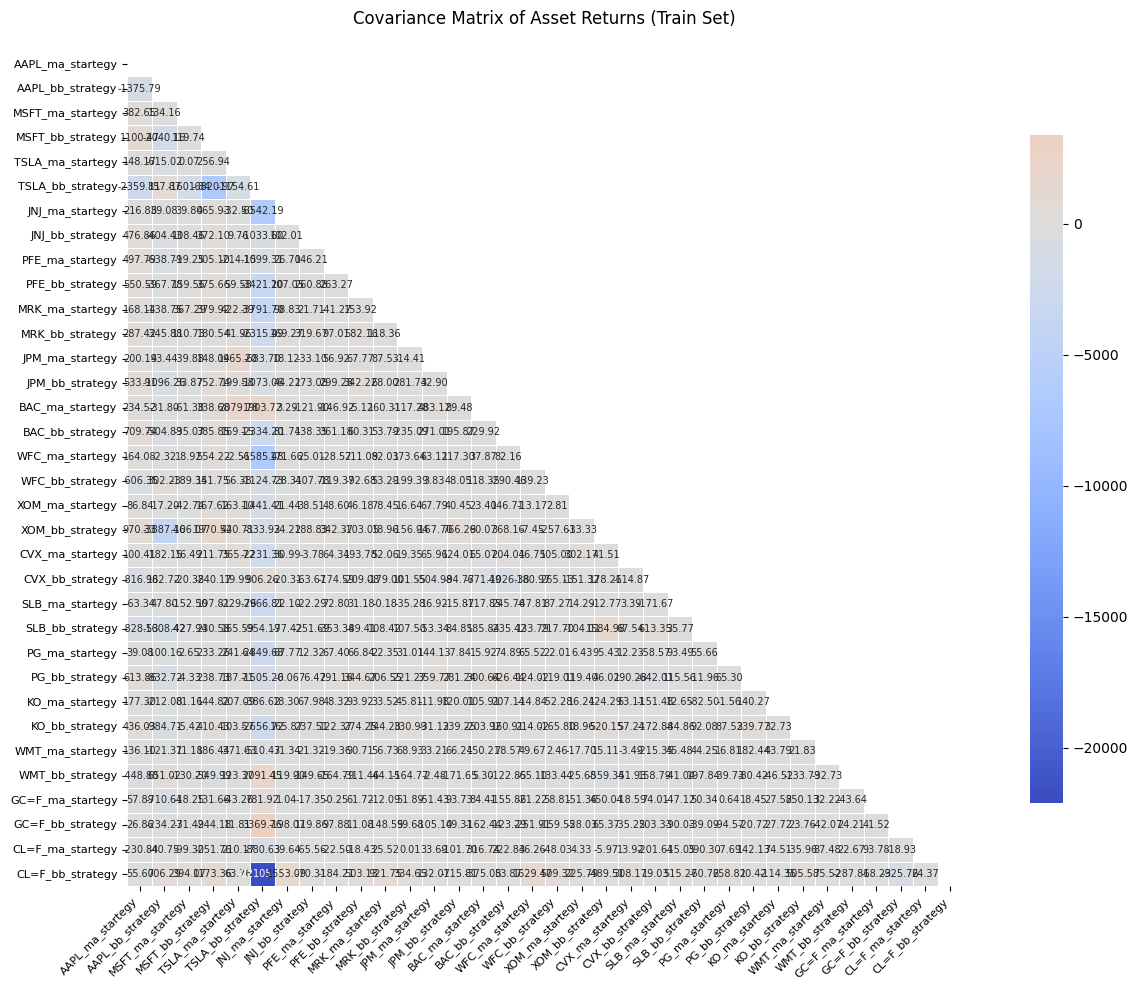

In [10]:
mask = np.triu(np.ones_like(cov_matrix, dtype=bool))       # hide upper triangle

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    cov_matrix,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    annot=True,           # set to False if you prefer no numbers
    fmt=".2f",
    annot_kws={"size": 7},
    linewidths=.5,
    cbar_kws={"shrink": .8},
    ax=ax,
)

# tidy up axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

ax.set_title("Covariance Matrix of Asset Returns (Train Set)", pad=20)
plt.tight_layout()
plt.show()

Niv

# Optimization (find the optimal weights for the portfolio on the training set)

## Optimization problem definition

*(definition used by `constrained_problem()`)*  

| Symbol | Meaning |
| :---: | --- |
| $n$ | number of assets |
| $\mathbf w \in \mathbb R^{n}$ | portfolio weights (decision variables) |
| $\Sigma = \texttt{cov\_mat}$ | empirical **co**-variance matrix of asset returns |
| $\boldsymbol\mu = \texttt{expected\_returns}$ | vector of expected asset returns |
| $r_{\min}$ | minimum acceptable portfolio return (argument **`min_return`**, default $0.05 \equiv 5\%$) |

---

#### 1 . Objective (target) function  

Minimise portfolio variance  

$$
\boxed{\displaystyle \min_{\mathbf w}\; f(\mathbf w)=\mathbf w^{\top}\Sigma\,\mathbf w}
$$  

**Gradient and Hessian**

$$
\nabla f(\mathbf w)=2\Sigma\,\mathbf w,
\qquad
\nabla^{2} f = 2\Sigma .
$$

---

#### 2 . Equality constraint  

Full-investment (budget):

$$
\boxed{\mathbf 1^{\top}\mathbf w = 1}
$$

Encoded as  
`eq_constraints_mat_aa = [[1, … , 1]]` &nbsp;&nbsp; `eq_constraints_rhs_aa = [1]`.

---

#### 3 . Inequality constraints  

| # | Constraint $g(\mathbf w)\le 0$ | Interpretation |
|---|--------------------------------|----------------|
| **0** | $g_{0}(\mathbf w)= r_{\min}-\boldsymbol\mu^{\top}\mathbf w$ | enforce **expected return $\ge r_{\min}$** |
| **1 … n** | $g_{i}(\mathbf w)= -w_{i}$ | **no negative weights (Funds alloacation)** ⇒ $w_{i}\ge 0$ |

Each $g$ returns $(g,\;\nabla g,\;\nabla^{2}g)$ with a zero Hessian.

---

#### 4 . Problem class  

Convex **quadratic programme (QP)**:

$$
\begin{aligned}
\min_{\mathbf w}\;& \mathbf w^{\top}\Sigma\,\mathbf w \\[6pt]
\text{s.t.}\;& \mathbf 1^{\top}\mathbf w = 1 \quad &(\text{budget})\\[4pt]
& \boldsymbol\mu^{\top}\mathbf w \ge r_{\min} \quad &(\text{return})\\[4pt]
& \mathbf w \succeq 0 \quad &(\text{no negative asset allocation})
\end{aligned}
$$

`constrained_problem()` returns everything as expected by the interior-point solver:

```python
(f, A_eq, b_eq, ineq_functions)

In [11]:
FunctionEvaluationResult: TypeAlias = tuple[float, np.ndarray, Optional[np.ndarray]]

def constrained_problem(min_return: float = 0.05) -> tuple[FunctionEvaluationResult, np.ndarray, np.ndarray, list[callable]]:

    def f_aa(w: np.ndarray, eval_hessian: bool = True) -> FunctionEvaluationResult:
        """
        Asset Allocation function for testing.
        
        Parameters
        ----------
        w : np.ndarray
            Input vector.
        eval_hessian : bool, optional
            Whether to evaluate the Hessian. Default is True.
        Returns
        -------
        FunctionEvaluationResult
            Tuple containing function value, gradient, and Hessian (if eval_hessian is True).
        """
        f_val = w.T @ cov_mat @ w
        grad = 2 * cov_mat @ w
        hess = 2 * cov_mat if eval_hessian else None
        return f_val, grad, hess

    # Define the equality constraints for the asset allocation problem: sum of weights equals 1
    eq_constraints_mat_aa = np.ones((1, cov_mat.shape[0]))
    eq_constraints_rhs_aa = np.array([1.0])

    # Solver expectation is g(x) <= 0
    # Define the inequality constraints for the asset allocation problem: expected returns >= 5
    zero_matrix = np.zeros_like(cov_mat)

    ineq_aa = [
        lambda w, eval_hessian=True: (
            min_return - expected_returns @ w,   # g(w) ≤ 0  ⇔  μᵀw ≥ min_return
            -expected_returns,
            zero_matrix
        )
    ]

    # ─── w_i ≥ 0   ⇒   g_i(w) = -w_i ≤ 0  for every i ─────────
    def make_nonneg(i: int) -> callable:
        g_vec = np.zeros(cov_mat.shape[0]);  g_vec[i] = -1      # ∇g_i = -e_i
        def g_i(w, *, eval_hessian=True):
            return -w[i], g_vec, zero_matrix           # g_i(w) ≤ 0  ⇔ w_i ≥ 0
        return g_i

    for i in range(cov_mat.shape[0]):
        ineq_aa.append(make_nonneg(i))

    return f_aa, eq_constraints_mat_aa, eq_constraints_rhs_aa, ineq_aa

In [12]:
def optimize_portfolio(min_return: float = 0.05) -> np.ndarray:
    f_aa, A_eq, b_eq, ineqs = constrained_problem(min_return)
    solver = ConstrainedMin()
    x0 = solver.phase1_feasible(A_eq, b_eq, ineqs)
    x_star = solver.interior_pt(
        f=f_aa,
        ineq_constraints=ineqs,
        eq_constraints_mat=A_eq,
        eq_constraints_rhs=b_eq,
        x0=x0
    )
    return x_star

## Explore efficient frontier to find the optimal min return value

### Using the Sharpe ratio to choose the best $r_{\min}$

Goal → pick the return floor $r_{\min}$ that maximises **risk-adjusted performance**.

---

#### 1 . Sharpe ratio

$$
\text{SR} \;=\; \frac{E[R]}{\sigma},
\qquad \text{(risk-free rate }=0)
$$

* $E[R]$ – expected portfolio return  
* $\sigma$ – portfolio volatility (standard deviation)  
* Higher $\text{SR}$ ⇒ more return **per unit of risk**.

---

#### 2 . Grid-search workflow

1. For each candidate $r_{\min}$  
   → solve the QP → obtain $(E[R],\sigma)$  
2. Compute $\text{SR}=E[R]/\sigma$  
3. Select  

$$
\operatorname*{arg\,max}_{i}\;\text{SR}_i
$$

The selected point (red ★) is the portfolio with the **steepest reward-to-risk slope** on the efficient frontier.

---

#### 3 . Why maximise Sharpe?

* Balances **return and risk** instead of chasing raw return.  
* Produces robust portfolios in general (including out-of-sample).  

The accompanying code builds `efficient_frontier`, adds a `Sharpe_Ratio` column, and highlights this optimal point.

In [13]:
# First, let's find the range of feasible returns
min_possible_return = expected_returns.min()
max_possible_return = expected_returns.max()
print(f"Expected returns range: {min_possible_return:.4f} to {max_possible_return:.4f}")

# Use a more reasonable range for optimization
min_return_range = np.linspace(min_possible_return * 0.1, max_possible_return * 0.9, 20)

returns = []
risk = []
successful_min_returns = []

for min_return in min_return_range:
    print(f"Optimizing portfolio for minimum return: {min_return:.4f}")
    try:
        x_star_aa = optimize_portfolio(min_return=min_return)    
        portfolio_return = expected_returns @ x_star_aa
        portfolio_risk = x_star_aa.T @ cov_mat @ x_star_aa
        
        returns.append(portfolio_return)
        risk.append(portfolio_risk)
        successful_min_returns.append(min_return)
        print(f"  -> Success: Return={portfolio_return:.4f}, Risk={portfolio_risk:.6f}")
        
    except (ValueError, RuntimeError) as e:
        print(f"  -> Failed: {str(e)}")
        continue


Expected returns range: -108.3356 to 46.6211
Optimizing portfolio for minimum return: -10.8336
[outer 1] t=1.0e+01, f=35.9412
[outer 2] t=1.0e+02, f=3.54612
[outer 3] t=1.0e+03, f=0.320505
[outer 4] t=1.0e+04, f=0.00471459
[outer 5] t=1.0e+05, f=-0.0260113
[outer 6] t=1.0e+06, f=-0.0290718
[outer 7] t=1.0e+07, f=-0.0293778
[outer 8] t=1.0e+08, f=-0.0294084
[outer 1] t=1.0e+01, f=-8.54458
[outer 2] t=1.0e+02, f=-8.54458
[outer 3] t=1.0e+03, f=-8.54458
[outer 4] t=1.0e+04, f=-9.02636
[outer 5] t=1.0e+05, f=-9.13018
[outer 6] t=1.0e+06, f=-9.13018
[outer 7] t=1.0e+07, f=-9.13018
[outer 8] t=1.0e+08, f=-9.13065
  -> Success: Return=1.6682, Risk=-9.130654
Optimizing portfolio for minimum return: -8.0550
[outer 1] t=1.0e+01, f=35.9419
[outer 2] t=1.0e+02, f=3.54682
[outer 3] t=1.0e+03, f=0.321048
[outer 4] t=1.0e+04, f=0.00475818
[outer 5] t=1.0e+05, f=-0.0260112
[outer 6] t=1.0e+06, f=-0.0290718
[outer 7] t=1.0e+07, f=-0.0293778
[outer 8] t=1.0e+08, f=-0.0294084
[outer 1] t=1.0e+01, f=-9.85

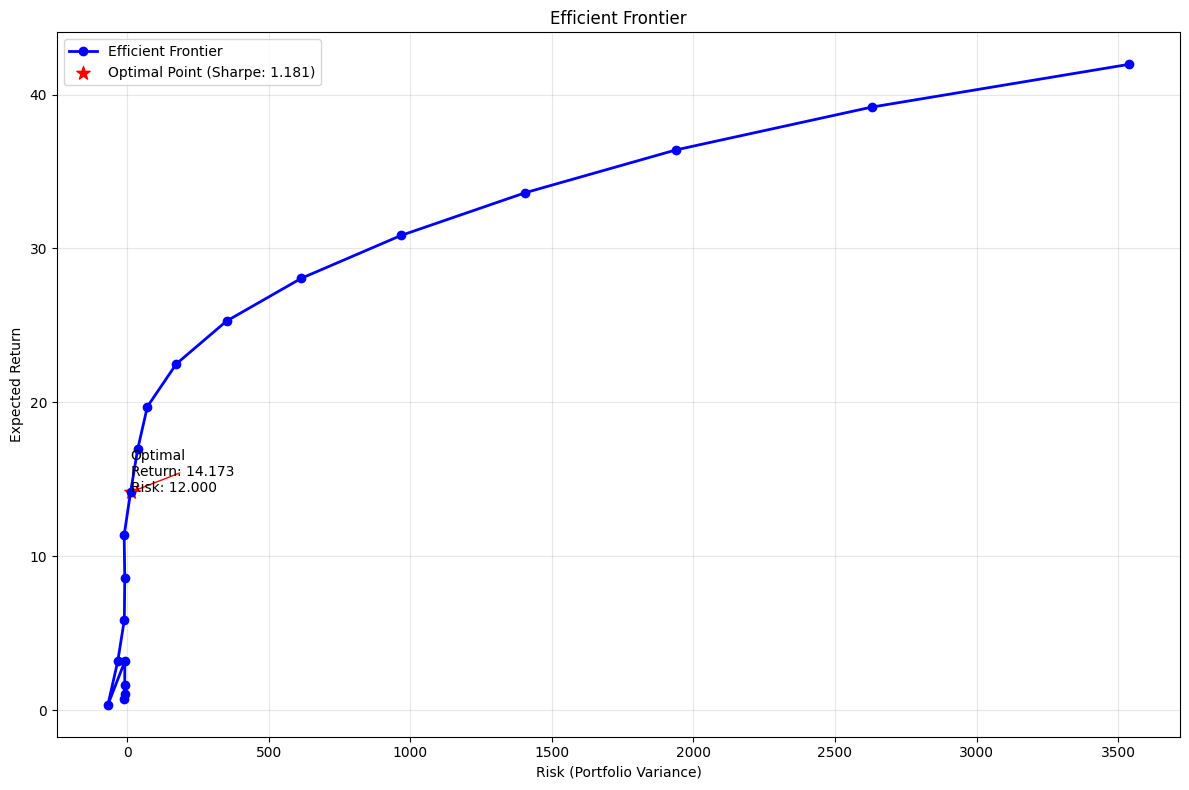

Optimal minimum return for maximum Sharpe ratio: 14.173457
Maximum Sharpe ratio: 1.181133


In [20]:
# Create a DataFrame for easier analysis
efficient_frontier = pd.DataFrame({
    'Min_Return_Target': successful_min_returns,
    'Return': returns,
    'Risk': risk
})

# Calculate Sharpe ratio (return/risk) for each point
efficient_frontier['Sharpe_Ratio'] = efficient_frontier['Return'] / efficient_frontier['Risk']

# Find the point with maximum Sharpe ratio
max_sharpe_idx = efficient_frontier['Sharpe_Ratio'].idxmax()
optimal_return = efficient_frontier.loc[max_sharpe_idx, 'Return']
optimal_risk = efficient_frontier.loc[max_sharpe_idx, 'Risk']

# Plot the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(efficient_frontier['Risk'], efficient_frontier['Return'], 'b-o', linewidth=2, markersize=6, label='Efficient Frontier')
plt.scatter(optimal_risk, optimal_return, color='red', s=100, marker='*', label=f'Optimal Point (Sharpe: {efficient_frontier.loc[max_sharpe_idx, "Sharpe_Ratio"]:.3f})')

plt.xlabel('Risk (Portfolio Variance)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.grid(True, alpha=0.3)
plt.legend()

# Annotate the optimal point
plt.annotate(f'Optimal\nReturn: {optimal_return:.3f}\nRisk: {optimal_risk:.3f}', 
             xy=(optimal_risk, optimal_return), 
             xytext=(optimal_risk + 0.001, optimal_return + 0.002),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

print(f"Optimal minimum return for maximum Sharpe ratio: {efficient_frontier.loc[max_sharpe_idx, 'Return']:.6f}")
print(f"Maximum Sharpe ratio: {efficient_frontier.loc[max_sharpe_idx, 'Sharpe_Ratio']:.6f}")


In [15]:
optimal_weights = optimize_portfolio(min_return=14.1)
print("Optimal Weights:", optimal_weights)

[outer 1] t=1.0e+01, f=35.9476
[outer 2] t=1.0e+02, f=3.55261
[outer 3] t=1.0e+03, f=0.3272
[outer 4] t=1.0e+04, f=0.0127327
[outer 5] t=1.0e+05, f=-0.0177598
[outer 6] t=1.0e+06, f=-0.0208181
[outer 7] t=1.0e+07, f=-0.0211241
[outer 8] t=1.0e+08, f=-0.0211547
[outer 1] t=1.0e+01, f=15.8668
[outer 2] t=1.0e+02, f=15.8668
[outer 3] t=1.0e+03, f=11.8705
[outer 4] t=1.0e+04, f=11.5769
[outer 5] t=1.0e+05, f=11.4929
[outer 6] t=1.0e+06, f=11.3804
[outer 7] t=1.0e+07, f=11.3804
[outer 8] t=1.0e+08, f=11.3784
Optimal Weights: [2.37457376e-01 5.26446204e-02 6.51236874e-03 8.12182145e-04
 5.19948274e-03 5.02751640e-02 8.34208854e-07 1.60488797e-02
 2.04119252e-02 1.39087949e-02 1.30108116e-06 5.07297919e-05
 3.74789186e-06 4.86172067e-05 3.53990968e-05 1.11710611e-06
 1.03050264e-06 2.31640340e-02 4.69963336e-04 9.10013257e-03
 1.16656014e-02 4.14494667e-03 2.23502609e-02 1.25581484e-01
 3.75410205e-07 2.42449925e-06 3.93376428e-06 1.34447244e-06
 4.44634080e-06 8.46379606e-02 3.81096340e-08 5

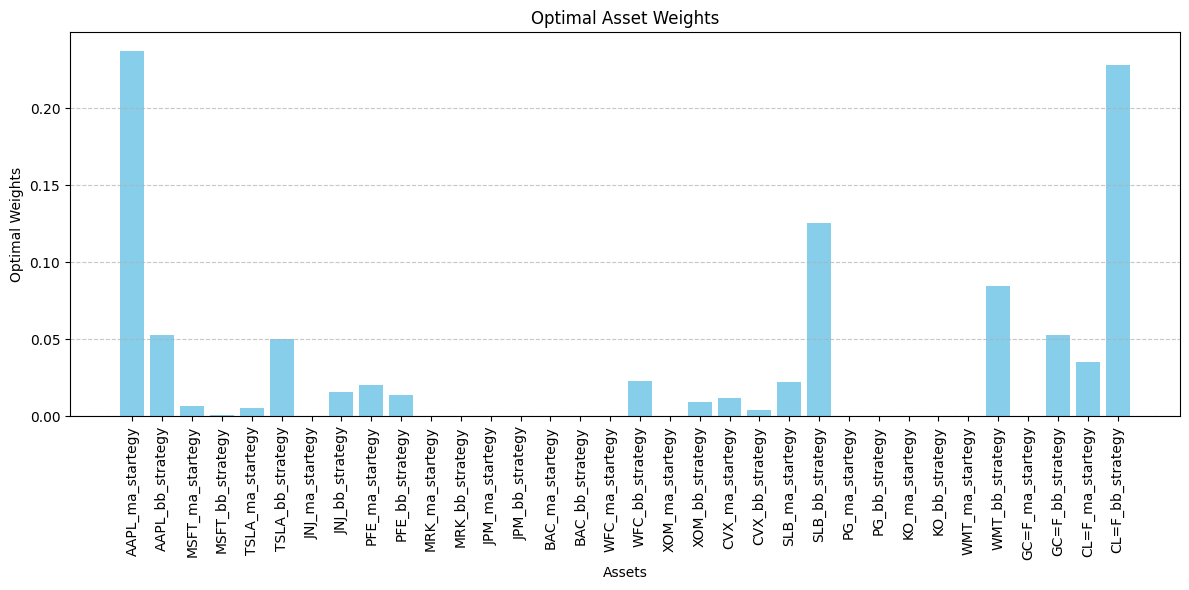

In [16]:
# Bar plot of optimal weights and their corresponding labels
labels = train_pnls.columns
plt.figure(figsize=(12, 6))
plt.bar(labels, optimal_weights, color='skyblue')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Asset Weights')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
def plot_cumulative_returns(pnls: pd.DataFrame, optimal_weights: np.ndarray, split: str):
    """
    Plot cumulative returns from a DataFrame of PnLs.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing PnLs for each strategy.
    title : str
        Title for the plot.
    """
    # Introduce cumulative returns pd.DataFrame for all the strategies
    cumulative_returns = pd.DataFrame(index=pnls.index)
    for col in pnls.columns:
        cumulative_returns[col] = np.cumsum(pnls[col].fillna(0))
    
    # Plot all cumulative returns on single graph
    plt.figure(figsize=(14, 8))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
    plt.title(f"Cumulative Returns of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the average cumulative return of all strategies graph
    average_cumulative_return = cumulative_returns.mean(axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(average_cumulative_return.index, average_cumulative_return, label='Average Cumulative Return', color='blue')
    plt.title(f"Average Cumulative Return of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Average Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the weighted cumulative return of all strategies graph using optimal weights
    weighted_cumulative_return = (cumulative_returns * optimal_weights).sum(axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(weighted_cumulative_return.index, weighted_cumulative_return, label='Weighted Cumulative Return', color='green')
    plt.title(f"Weighted Cumulative Return of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Weighted Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

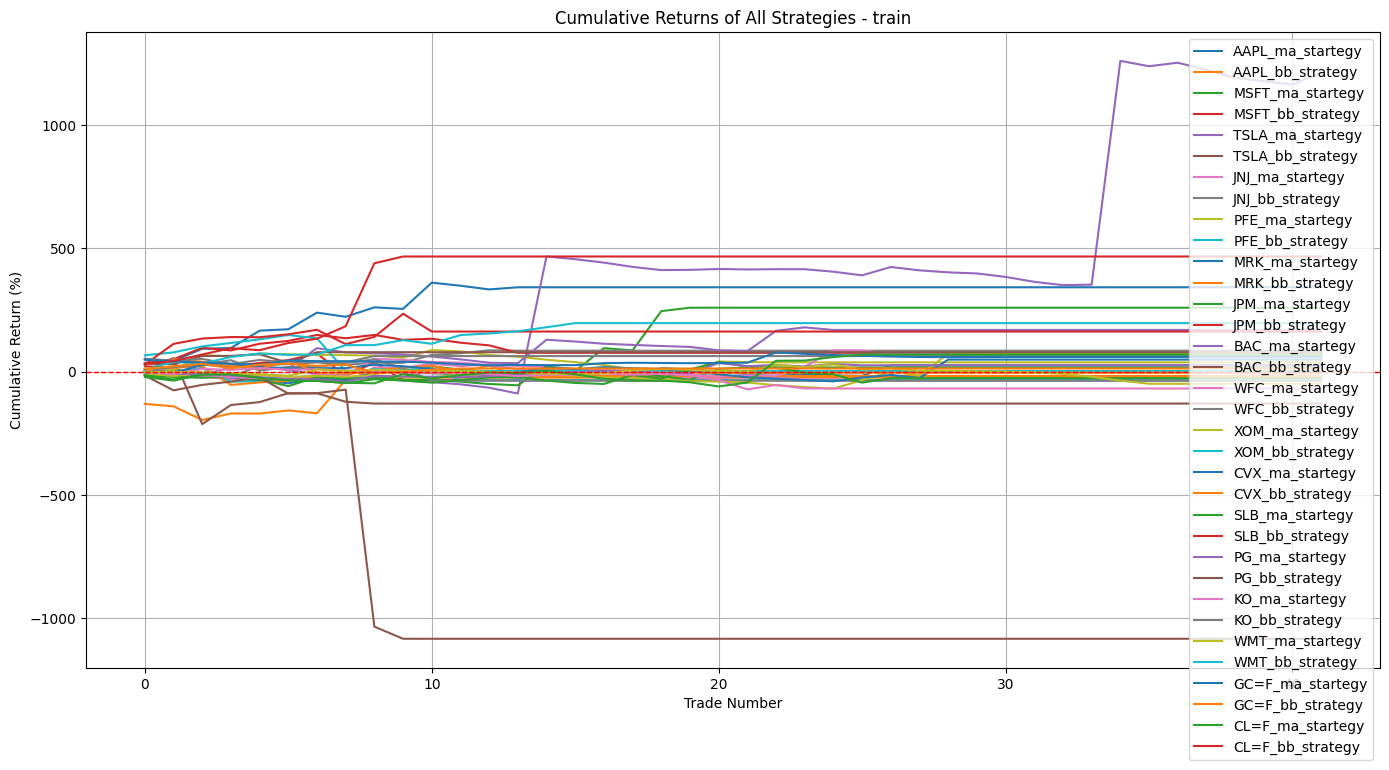

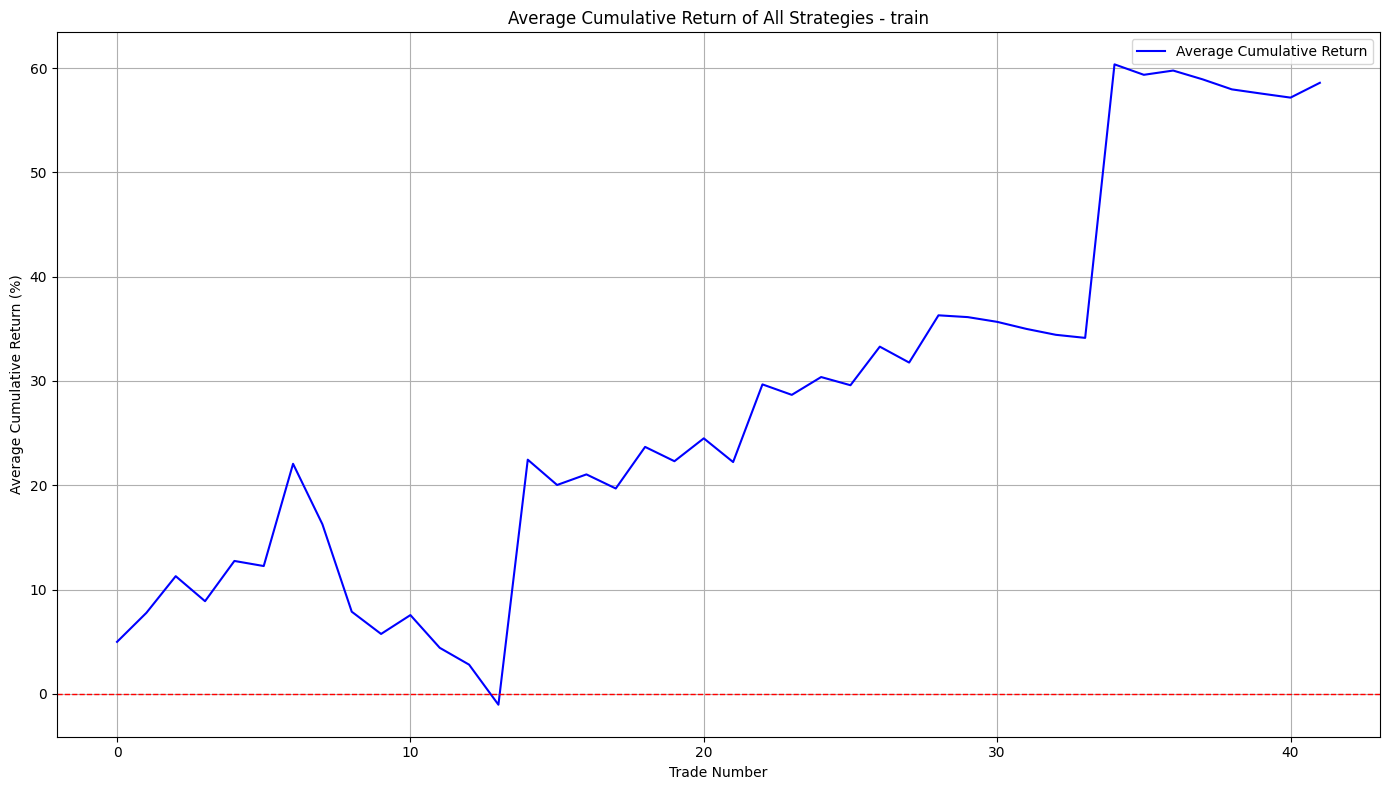

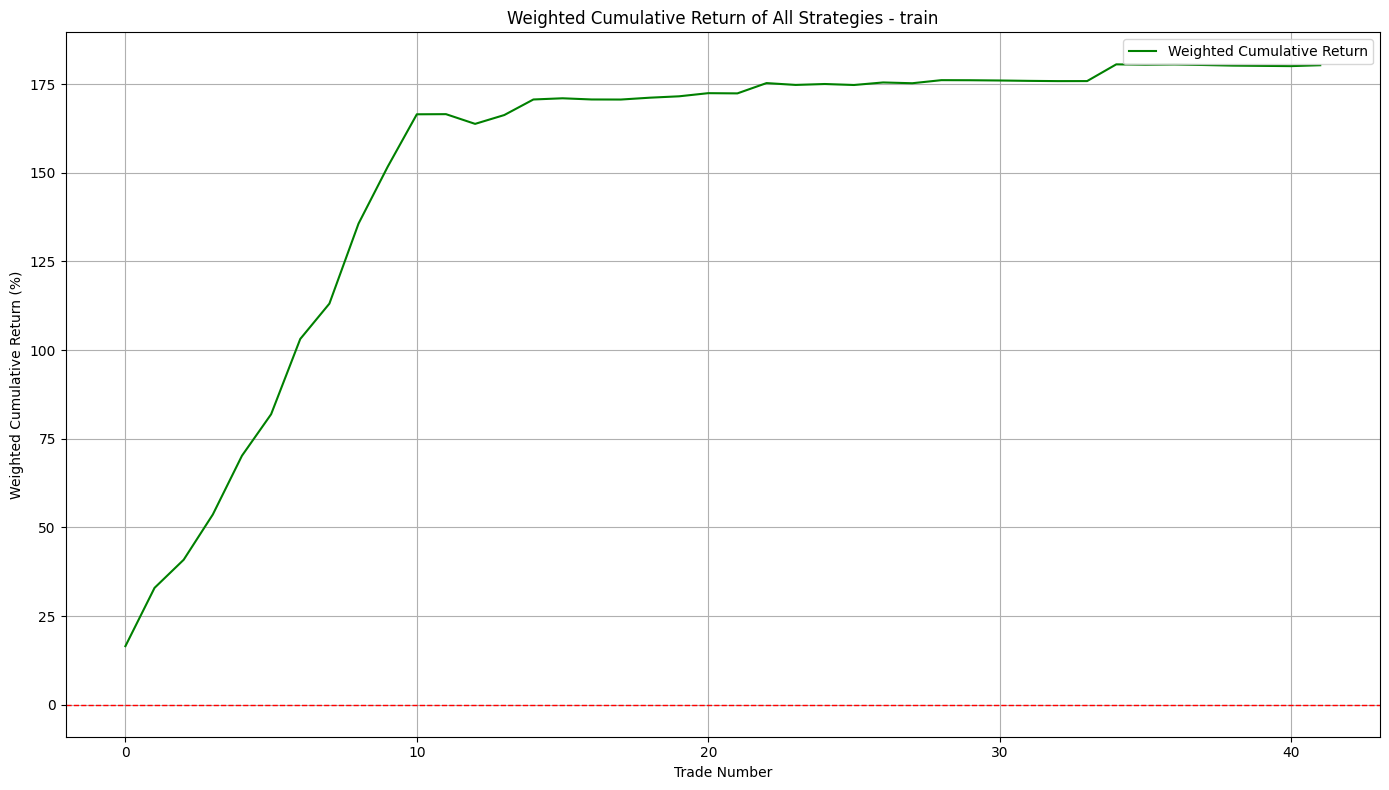

In [18]:
plot_cumulative_returns(train_pnls, optimal_weights, "train")

Processing strategies for tech sector...
Finished processing strategies for tech sector.

Processing strategies for healthcare sector...
Finished processing strategies for healthcare sector.

Processing strategies for financials sector...
Finished processing strategies for financials sector.

Processing strategies for energy sector...
Finished processing strategies for energy sector.

Processing strategies for consumer sector...
Finished processing strategies for consumer sector.

Processing strategies for commodities sector...
Finished processing strategies for commodities sector.

Finished processing strategies for energy sector.

Processing strategies for consumer sector...
Finished processing strategies for consumer sector.

Processing strategies for commodities sector...
Finished processing strategies for commodities sector.



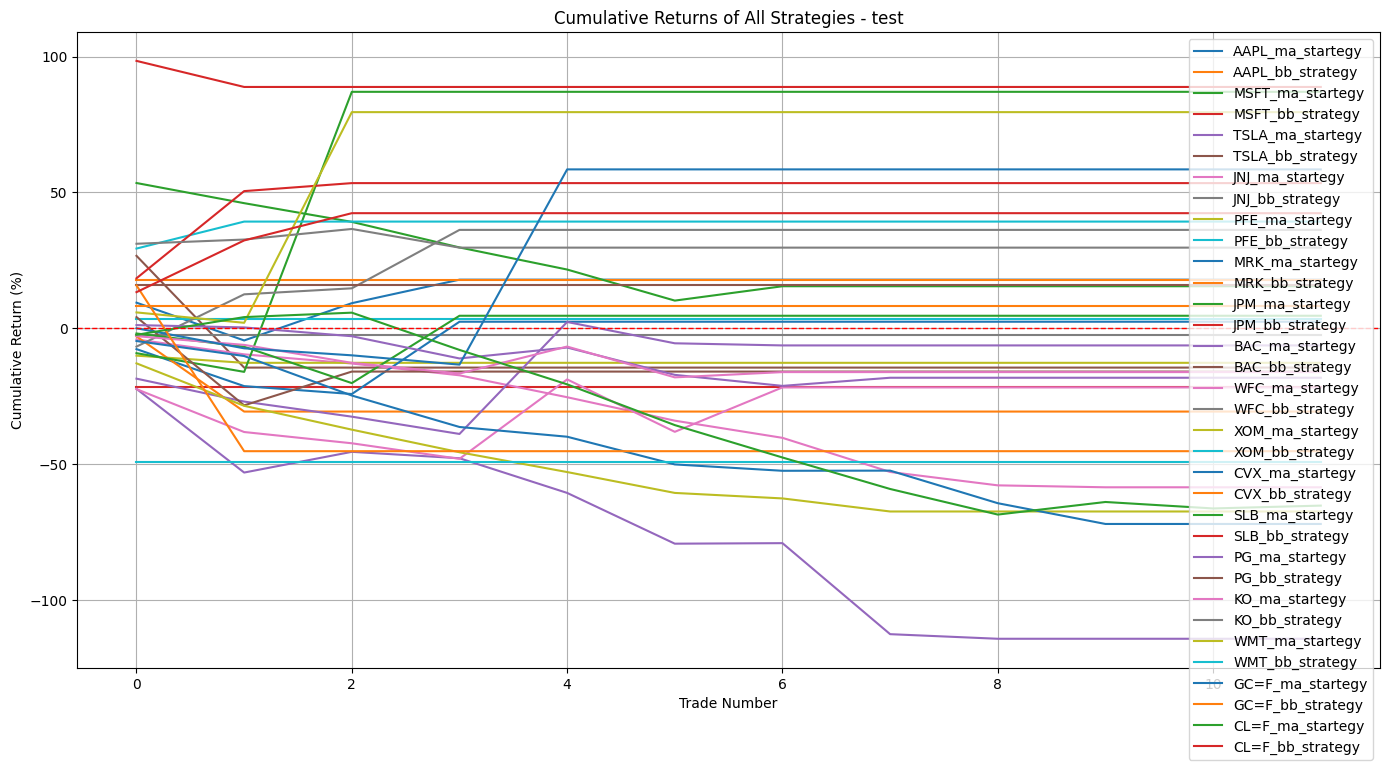

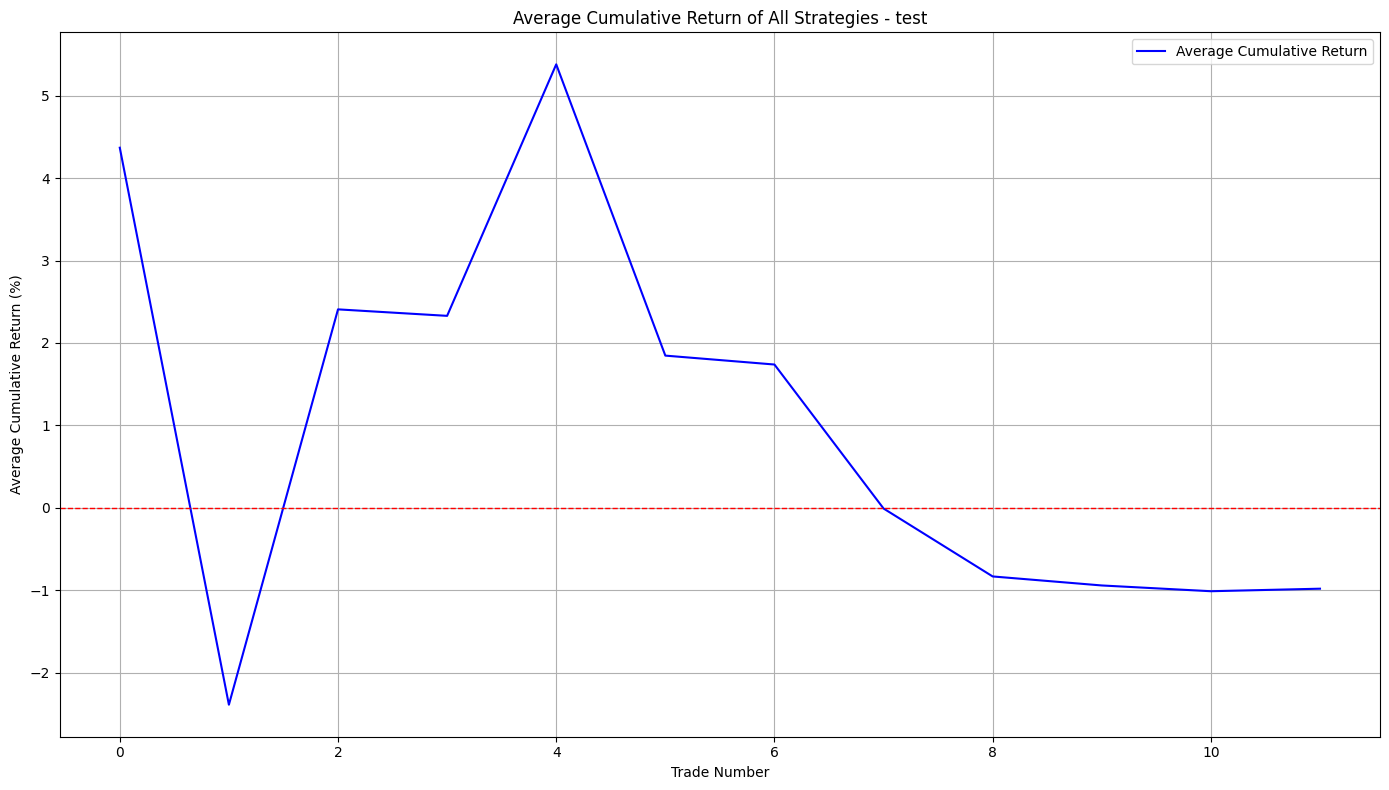

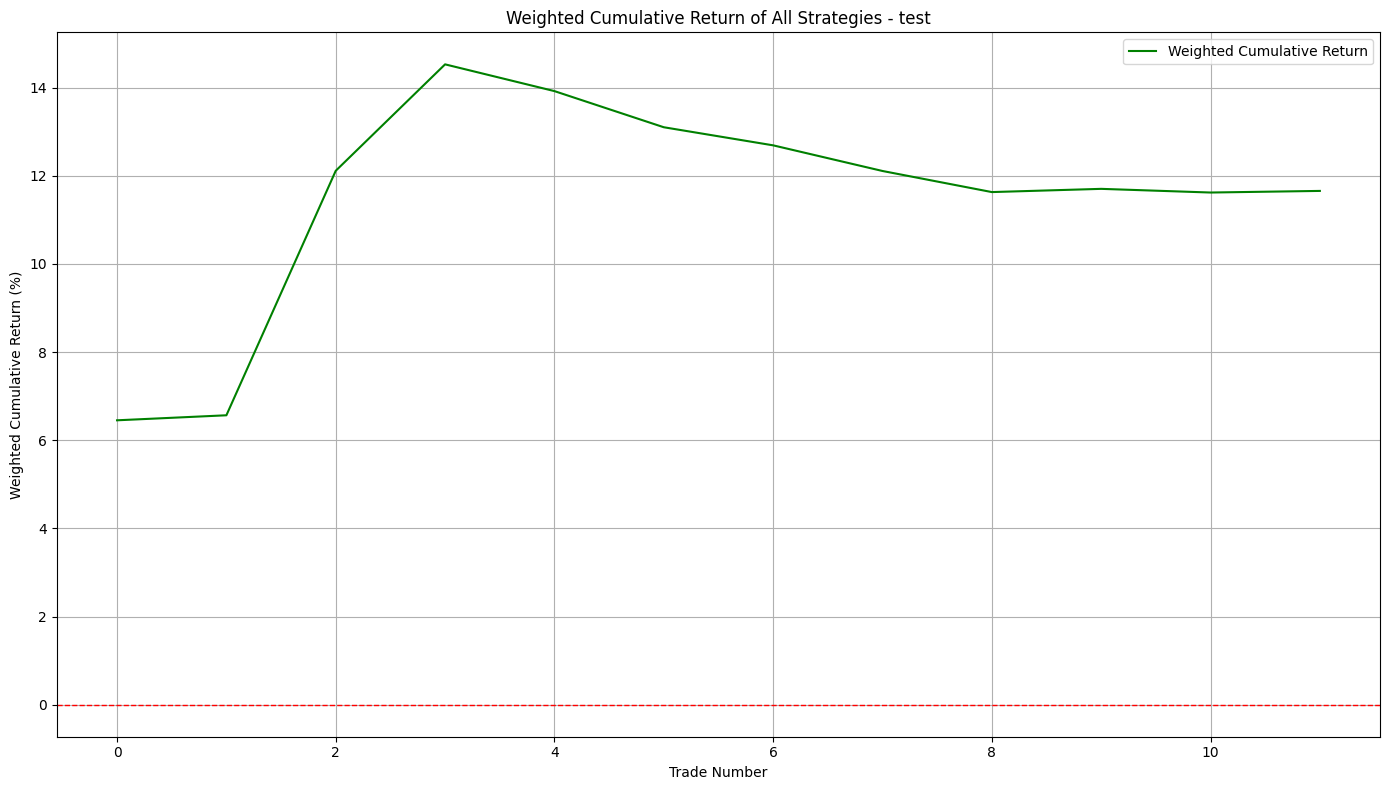

In [19]:
plot_cumulative_returns(generate_backtest_pnl("test"), optimal_weights, "test")